<a href="https://colab.research.google.com/github/roshansadath/COMP6721_Winter2023_GroupN/blob/main/Simple%20Chest%20XRay/Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models.inception import InceptionOutputs
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
data_path = "/content/drive/My Drive/Simple_Chest_XRay/"
#data_path = "/content/drive/My Drive/NIH_Chest_XRay/"
#data_path = "/content/drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 1
batch_size = 96
num_epochs = 20

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
def data_sampling(indices):
  return torch.utils.data.sampler.SubsetRandomSampler(indices)

In [ ]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

**DATA PREPROCESSING**


In [ ]:
data_transforms = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Get dataset from folder and apply data transforms
dataset = datasets.ImageFolder(root = "{}data".format(data_path), transform = data_transforms)
  
# Get a sample of the data randomly
num_samples = int(len(dataset) * sample_ratio)
indices = np.random.choice(range(len(dataset)), num_samples, replace = False)

# Split the data into training, test, and validation sets
train_size = int(0.7 * num_samples)
test_size = int(0.2 * num_samples)
val_size = num_samples - train_size - test_size

train_indices = indices[ : train_size]
test_indices = indices[train_size : train_size + test_size]
val_indices = indices[train_size + test_size : ]

samples = [data_sampling(i) for i in [train_indices, test_indices, val_indices]]

# Create data loaders for training, test, and validation sets
train_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[0], num_workers = 4, pin_memory = True)
test_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[1], num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[2], num_workers = 4, pin_memory = True)

 **DOWNLOAD RESNET18 MODEL AND TRAIN**


In [ ]:
# Define the ResNet18 model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained = False)
#num_ftrs = model.fc.in_features
model.fc = nn.Linear(2048, len(dataset.classes))
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "Inceptionv3", num_epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Epoch 1/20: 100%|██████████| 43/43 [01:35<00:00,  2.22s/batch, Accuracy=0.817, Loss=0.377, Precision=0.77, Recall=0.79, F1 Score=0.778]


VALIDATION: Accuracy: 0.7799 | Loss: 0.5302 | Recall: 0.5521 | Precision: 0.8870 | F-score: 0.5307



Epoch 2/20: 100%|██████████| 43/43 [01:35<00:00,  2.21s/batch, Accuracy=0.866, Loss=0.303, Precision=0.799, Recall=0.809, F1 Score=0.804]


VALIDATION: Accuracy: 0.8771 | Loss: 0.2929 | Recall: 0.8928 | Precision: 0.8288 | F-score: 0.8503



Epoch 3/20: 100%|██████████| 43/43 [01:36<00:00,  2.24s/batch, Accuracy=0.908, Loss=0.233, Precision=0.827, Recall=0.837, F1 Score=0.831]


VALIDATION: Accuracy: 0.8976 | Loss: 0.2413 | Recall: 0.9134 | Precision: 0.8517 | F-score: 0.8739



Epoch 4/20: 100%|██████████| 43/43 [01:37<00:00,  2.26s/batch, Accuracy=0.907, Loss=0.226, Precision=0.84, Recall=0.849, F1 Score=0.845]


VALIDATION: Accuracy: 0.9420 | Loss: 0.1664 | Recall: 0.9334 | Precision: 0.9147 | F-score: 0.9235



Epoch 5/20: 100%|██████████| 43/43 [01:35<00:00,  2.22s/batch, Accuracy=0.937, Loss=0.168, Precision=0.856, Recall=0.865, F1 Score=0.86]


VALIDATION: Accuracy: 0.9539 | Loss: 0.1310 | Recall: 0.9367 | Precision: 0.9387 | F-score: 0.9377



Epoch 6/20: 100%|██████████| 43/43 [01:37<00:00,  2.26s/batch, Accuracy=0.949, Loss=0.143, Precision=0.869, Recall=0.877, F1 Score=0.873]


VALIDATION: Accuracy: 0.9556 | Loss: 0.1276 | Recall: 0.9355 | Precision: 0.9439 | F-score: 0.9396



Epoch 7/20: 100%|██████████| 43/43 [01:37<00:00,  2.27s/batch, Accuracy=0.948, Loss=0.15, Precision=0.878, Recall=0.885, F1 Score=0.881]


VALIDATION: Accuracy: 0.9573 | Loss: 0.1250 | Recall: 0.9436 | Precision: 0.9416 | F-score: 0.9426



Epoch 8/20: 100%|██████████| 43/43 [01:38<00:00,  2.29s/batch, Accuracy=0.958, Loss=0.114, Precision=0.886, Recall=0.893, F1 Score=0.889]


VALIDATION: Accuracy: 0.9283 | Loss: 0.1866 | Recall: 0.9408 | Precision: 0.8888 | F-score: 0.9097



Epoch 9/20: 100%|██████████| 43/43 [01:37<00:00,  2.27s/batch, Accuracy=0.952, Loss=0.126, Precision=0.892, Recall=0.898, F1 Score=0.895]


VALIDATION: Accuracy: 0.9590 | Loss: 0.1138 | Recall: 0.9611 | Precision: 0.9340 | F-score: 0.9465



Epoch 10/20: 100%|██████████| 43/43 [01:40<00:00,  2.35s/batch, Accuracy=0.97, Loss=0.0788, Precision=0.899, Recall=0.904, F1 Score=0.902]


VALIDATION: Accuracy: 0.9505 | Loss: 0.1477 | Recall: 0.9555 | Precision: 0.9205 | F-score: 0.9360



Epoch 11/20: 100%|██████████| 43/43 [01:39<00:00,  2.31s/batch, Accuracy=0.968, Loss=0.0847, Precision=0.904, Recall=0.909, F1 Score=0.907]


VALIDATION: Accuracy: 0.9727 | Loss: 0.0925 | Recall: 0.9608 | Precision: 0.9652 | F-score: 0.9630



Epoch 12/20: 100%|██████████| 43/43 [01:41<00:00,  2.35s/batch, Accuracy=0.967, Loss=0.0889, Precision=0.909, Recall=0.914, F1 Score=0.911]


VALIDATION: Accuracy: 0.9744 | Loss: 0.0894 | Recall: 0.9643 | Precision: 0.9665 | F-score: 0.9654



Epoch 13/20: 100%|██████████| 43/43 [01:40<00:00,  2.33s/batch, Accuracy=0.981, Loss=0.0538, Precision=0.914, Recall=0.918, F1 Score=0.916]


VALIDATION: Accuracy: 0.9642 | Loss: 0.0992 | Recall: 0.9599 | Precision: 0.9456 | F-score: 0.9524



Epoch 14/20: 100%|██████████| 43/43 [01:42<00:00,  2.38s/batch, Accuracy=0.98, Loss=0.0477, Precision=0.918, Recall=0.922, F1 Score=0.92]


VALIDATION: Accuracy: 0.9710 | Loss: 0.0991 | Recall: 0.9480 | Precision: 0.9733 | F-score: 0.9598



Epoch 15/20: 100%|██████████| 43/43 [01:40<00:00,  2.34s/batch, Accuracy=0.978, Loss=0.0619, Precision=0.922, Recall=0.926, F1 Score=0.924]


VALIDATION: Accuracy: 0.9625 | Loss: 0.0945 | Recall: 0.9540 | Precision: 0.9458 | F-score: 0.9498



Epoch 16/20: 100%|██████████| 43/43 [01:42<00:00,  2.39s/batch, Accuracy=0.987, Loss=0.0375, Precision=0.926, Recall=0.929, F1 Score=0.927]


VALIDATION: Accuracy: 0.9556 | Loss: 0.1580 | Recall: 0.9167 | Precision: 0.9630 | F-score: 0.9371



Epoch 17/20: 100%|██████████| 43/43 [01:42<00:00,  2.38s/batch, Accuracy=0.973, Loss=0.0699, Precision=0.928, Recall=0.931, F1 Score=0.93]


VALIDATION: Accuracy: 0.9642 | Loss: 0.1020 | Recall: 0.9669 | Precision: 0.9412 | F-score: 0.9531



Epoch 18/20: 100%|██████████| 43/43 [01:43<00:00,  2.40s/batch, Accuracy=0.979, Loss=0.0501, Precision=0.931, Recall=0.934, F1 Score=0.932]


VALIDATION: Accuracy: 0.9505 | Loss: 0.1363 | Recall: 0.9649 | Precision: 0.9169 | F-score: 0.9370



Epoch 19/20: 100%|██████████| 43/43 [01:42<00:00,  2.38s/batch, Accuracy=0.985, Loss=0.0393, Precision=0.933, Recall=0.936, F1 Score=0.935]


VALIDATION: Accuracy: 0.9761 | Loss: 0.0813 | Recall: 0.9654 | Precision: 0.9699 | F-score: 0.9676



Epoch 20/20: 100%|██████████| 43/43 [01:44<00:00,  2.44s/batch, Accuracy=0.999, Loss=0.00811, Precision=0.936, Recall=0.939, F1 Score=0.938]


VALIDATION: Accuracy: 0.9676 | Loss: 0.1109 | Recall: 0.9551 | Precision: 0.9572 | F-score: 0.9562

[0.3769874434248358, 0.30307363940320614, 0.2327645721014432, 0.22649750860181195, 0.16796310725488964, 0.14283552790566403, 0.15007680729776804, 0.11449513055436872, 0.12593683003325032, 0.0787935916295311, 0.0847270052373831, 0.08888355461245748, 0.0538349934022262, 0.0477422634639513, 0.06186930652208868, 0.0375415647741399, 0.06990646385701582, 0.05013662610847387, 0.039299392175937274, 0.008109924719728226] [0.5302463362037932, 0.29285960921655335, 0.24129560121904053, 0.1663669791746465, 0.13096436406819487, 0.12764475876052225, 0.12504073324591022, 0.18655960409307643, 0.11378472419169576, 0.14766525774685596, 0.09247707663924011, 0.08941881192066156, 0.09923410139749074, 0.09907896211112567, 0.09448396988092277, 0.158043305996691, 0.10195146272127412, 0.13625418621118565, 0.08128262272123693, 0.110942240368969]


**SAVE MODEL PARAMETERS**

In [ ]:
torch.save(model.state_dict(), "{}inceptionv3.pth".format(data_path))

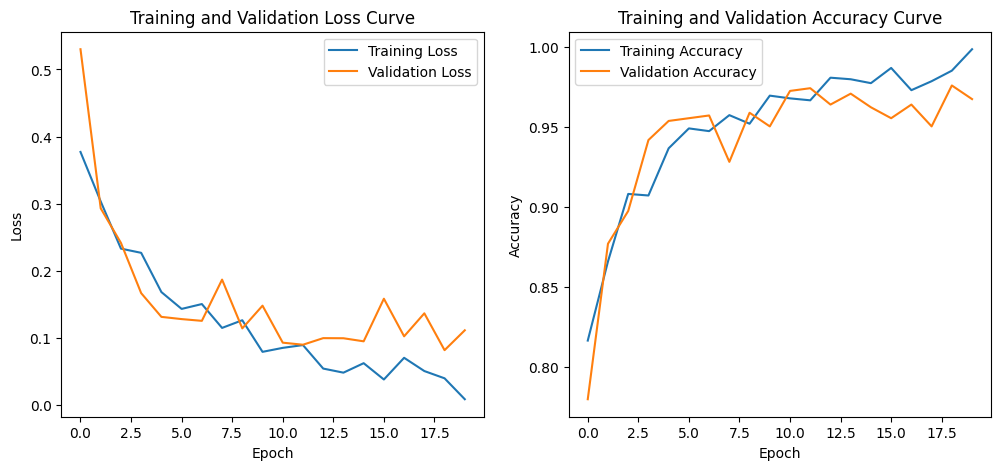

In [ ]:
#Plot the Accuracy and Loss Curves of the model for Training and Validation
plot_model_curves(losses, accuracies, v_accuracies, v_losses)

**EVALUATE MODEL ON VALIDATION AND TEST SET**

TEST: Accuracy: 0.9573 | Loss: 0.1781 | Recall: 0.9397 | Precision: 0.9508 | F-score: 0.9450



<Figure size 800x800 with 0 Axes>

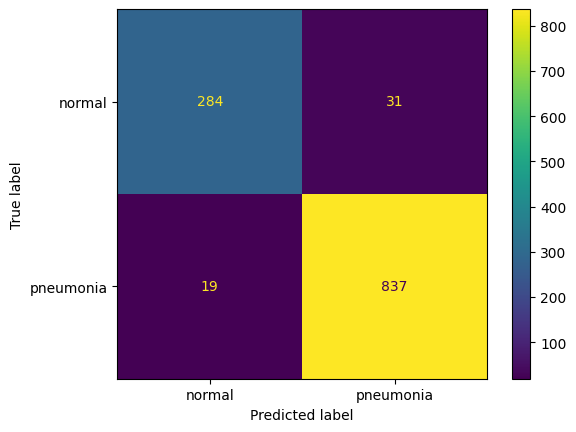

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "Inceptionv3")

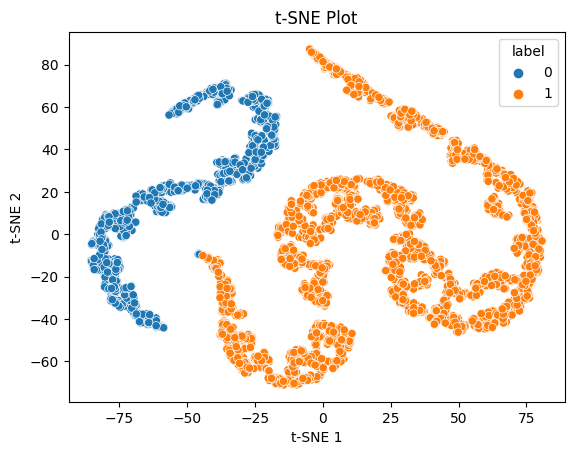

In [ ]:
#Obtain the TSNE Plot
plot_TSNE(train_loader, device, model)

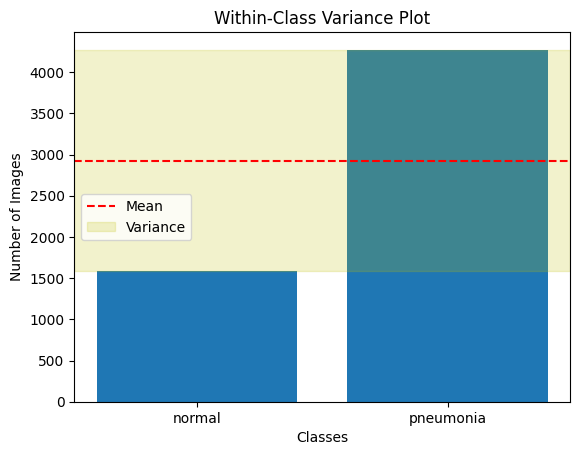

In [ ]:
#Plot the Within-Class Variance of the dataset
plot_within_class_variance(dataset)